In [2]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


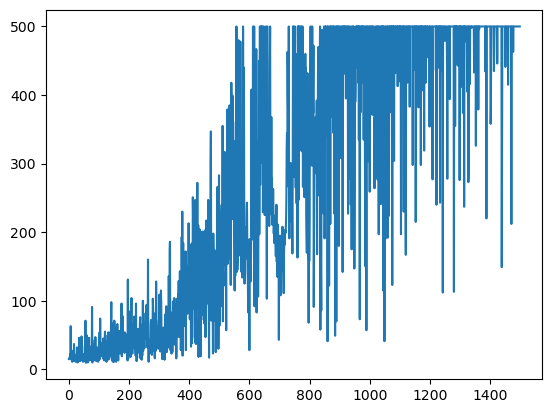

Average reward:  285.9033333333333


In [32]:
class actor_class(nn.Module):
    def __init__(self):
        super(actor_class,self).__init__()
        self.fc1 = nn.Linear(4,128)
        self.fc2 = nn.Linear(128,2)
    
    def forward(self,x):
        x = torch.tensor(x)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim = 0)
        return x

class critic_class(nn.Module):
    def __init__(self):
        super(critic_class,self).__init__()
        self.fc = nn.Linear(4,128)
        self.fc2 = nn.Linear(128,1)
    
    def forward(self,x):
        x = torch.tensor(x)
        x = torch.relu(self.fc(x))
        x = self.fc2(x)
        return x

actor = actor_class()
critic = critic_class()
actor_optimizer = torch.optim.Adam(actor.parameters(), lr = 1e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr = 1e-3)
gamma = 1.0
num_episodes = 1500

env = gym.make('CartPole-v1')

@torch.no_grad()
def get_action(state):
    with torch.no_grad():
        if random.random() < actor.forward(state)[0]:
            return 0
        else:
            return 1
    
rewards = []
for num_epoch in range(num_episodes):
    if num_epoch == 800:
        actor_optimizer = torch.optim.Adam(actor.parameters(), lr = 1e-5)
        critic_optimizer = torch.optim.Adam(critic.parameters(), lr = 1e-4)
    if num_epoch == 1200:
        actor_optimizer = torch.optim.Adam(actor.parameters(), lr = 0.5e-5)
        critic_optimizer = torch.optim.Adam(critic.parameters(), lr = 0.5e-4)
    if num_epoch % 100 == 0:
        print(num_epoch)
    state, _ = env.reset()
    I = 1
    tot_reward = 0
    while True:
        action = get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        tot_reward += reward
        cur_state_value = critic.forward(state)
        
        if terminated or truncated:
            next_state_value = 0
        else:
            next_state_value = critic.forward(next_state)

        td_error = reward + gamma * next_state_value - cur_state_value
        
        critic_loss = td_error ** 2

        actor_loss = I * td_error.detach() * -1 * torch.log(actor.forward(state)[action])

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step() 

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()        


        if terminated or truncated:
            rewards.append(tot_reward)
            break
        state = next_state
        I *= gamma
plt.plot(rewards)
plt.show()
print("Average reward: ", sum(rewards) / num_episodes)

In [34]:
tot_reward = 0
num_tests = 1000
for _ in range(num_tests):
    state, _ = env.reset()
    while True:
        action = get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        tot_reward += reward
        if terminated or truncated:
            break
        state = next_state
print(tot_reward / num_tests)

481.058


In [ ]:
env = gym.make('CartPole-v1', render_mode = "human")
state, _ = env.reset()
while True:
    action = get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    state = next_state
env.close()